In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize #package for flattening json in pandas df
with open('gbfs.json') as f:
    d = json.load(f)
feeds = json_normalize(d['data']['en']['feeds']) 
feeds.head()
with open('station_information.json') as f:      #this file was collected from: https://www.lyft.com/bikes/bay-wheels/system-data
    s = json.load(f)
station_info = json_normalize(s['data']['stations'])
print(station_info.columns)

print(station_info.shape)
print(station_info.describe(include='all'))

#drop cols with unique =1 as well as some others we dont need 
station_info.drop(labels = ['rental_uris.ios', 
                            'rental_uris.android',
                            'eightd_has_key_dispenser',
                            'eightd_station_services',
                            'electric_bike_surcharge_waiver',
                            'station_type', 'has_kiosk',
                           'rental_methods'], axis=1, inplace=True)
station_info.dtypes
#coerce remaining categorical cols
catcols = ['short_name', 'external_id','station_id', 'region_id', 'name']
for c in catcols:
    station_info[c] = station_info[c].astype('category')
print(station_info.dtypes)
cols = station_info.columns.tolist()
cols = [ 'region_id', 'short_name','station_id',
        'capacity', 'lon','lat',
        'external_id']
station_info = station_info[cols]
station_info.head()


Index(['eightd_has_key_dispenser', 'short_name', 'lat', 'external_id',
       'station_id', 'capacity', 'region_id', 'lon', 'has_kiosk',
       'rental_methods', 'name', 'station_type',
       'electric_bike_surcharge_waiver', 'eightd_station_services',
       'rental_uris.ios', 'rental_uris.android'],
      dtype='object')
(454, 16)
       eightd_has_key_dispenser short_name         lat  \
count                       454        454  454.000000   
unique                        1        454         NaN   
top                       False      OK-I9         NaN   
freq                        454          1         NaN   
mean                        NaN        NaN   37.709391   
std                         NaN        NaN    0.178052   
min                         NaN        NaN   37.309014   
25%                         NaN        NaN   37.747439   
50%                         NaN        NaN   37.777234   
75%                         NaN        NaN   37.801978   
max                       

,region_id,short_name,station_id,capacity,lon,lat,external_id
0,3,SF-G27,3,35,-122.404904,37.786375,1b13a386-c5f4-42cc-bc3b-ded95982e090
1,3,SF-G26,4,35,-122.408915,37.785881,a00d04e6-0159-466a-b3ab-23f9550f418c
2,3,SF-H26,5,35,-122.408445,37.783899,a1e0b4b2-2c5c-4201-a78c-9e8a2152ab4e
3,3,SF-A27,6,23,-122.403234,37.804770,23a2bad4-3ea1-4545-87eb-acbee3efccfc
4,12,OK-L5,7,35,-122.271738,37.804562,9e3efff1-3d42-46fd-8206-4021277ba6c2


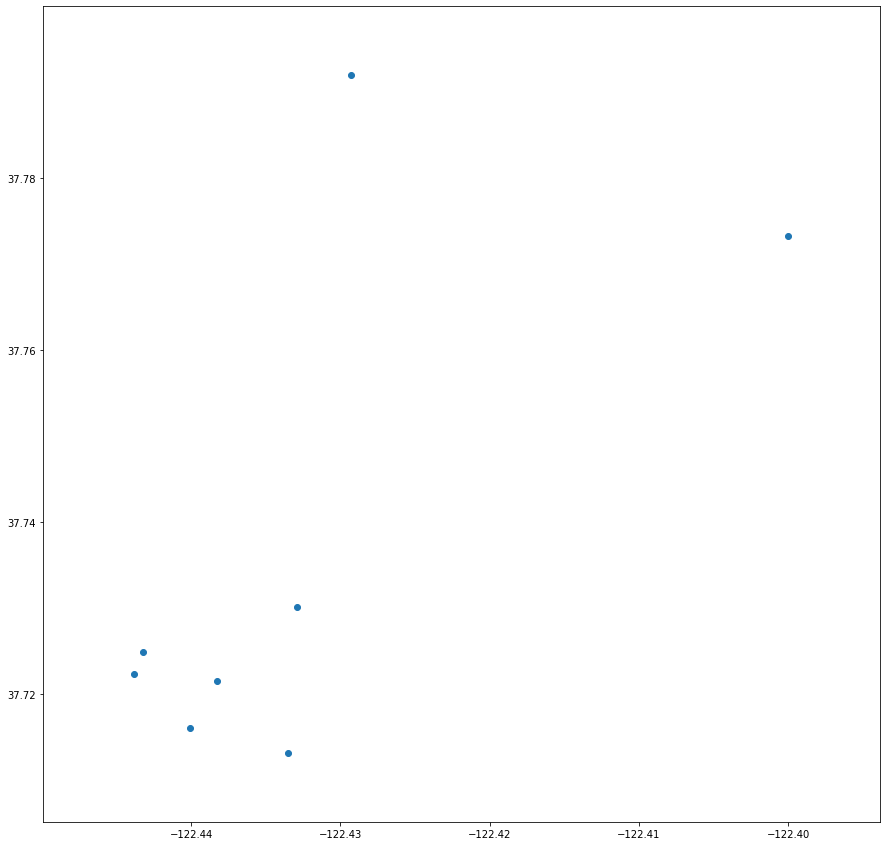

In [2]:

station_info.sort_values(by=['region_id','short_name'], ascending=True)
#oops found some nans on the region id
station_info.region_id.isnull().sum()
noregion = station_info.region_id.isnull()
#lets see where they are
fig,ax = plt.subplots(figsize=(15,15))
ax.scatter(station_info[noregion].lon, station_info[noregion].lat )
    #will be better on a map. 


In [3]:
#pip install descartes geopandas 
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd

from shapely.geometry import Point, Polygon
%matplotlib inline
crs = {'init': 'epsg:4326'}


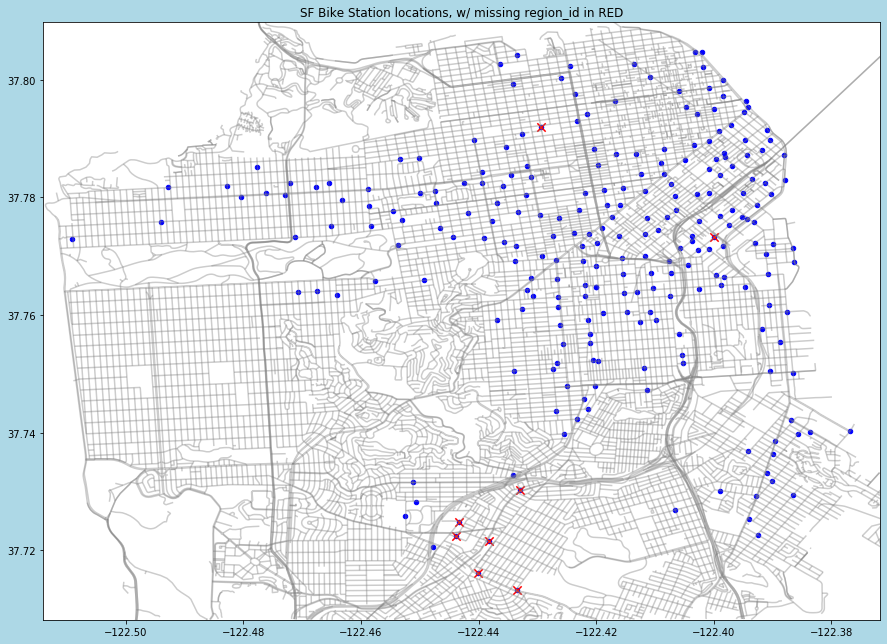

In [4]:
#instantiate a geodataframe 

#create the point objects in series
geometry = [Point(xy) for xy in zip( station_info.lon, station_info.lat)]  #long, lat! == x,y 

geo_df = gpd.GeoDataFrame(station_info.copy(),
                         crs =crs,
                         geometry = geometry)

#setup some filters
excl_southbay  = geo_df.lat > 37.5
excl_eastbay  = geo_df.lon < -122.30
eastbay = ~excl_eastbay & excl_southbay    #just in case will want to see if trips are recorded between sf an east
sf_proper = excl_eastbay & excl_southbay

#lets look at region_id now
geo_df[sf_proper]['region_id'].value_counts() #SF region_id = 3
geo_df[eastbay]['region_id'].value_counts() #eastbay region_id in {12,13,14}
geo_df[~excl_southbay]['region_id'].value_counts()  # southbay region id = 5
#...good, we can use the either method to filter directly 


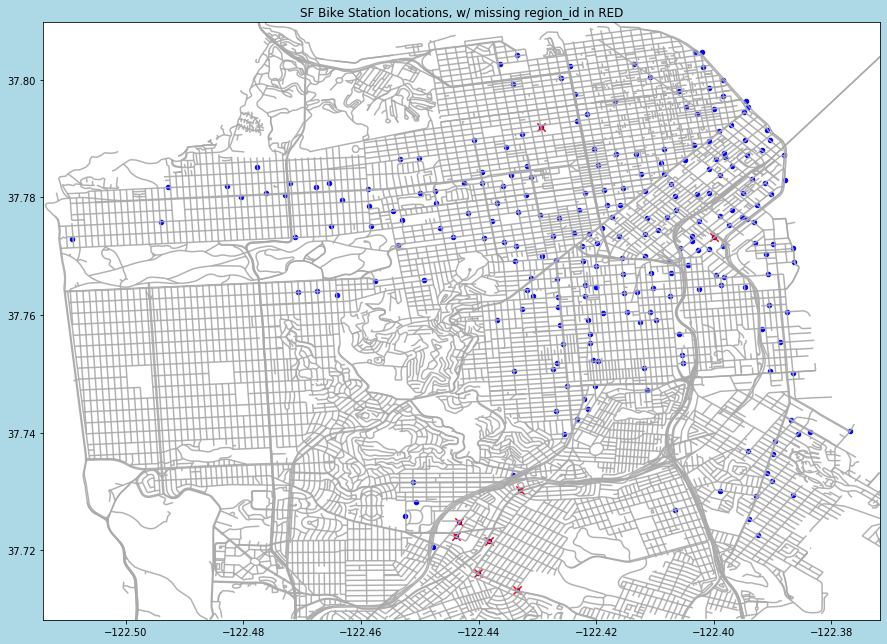

In [27]:

#visualize where the missing values are
fig,ax = plt.subplots(figsize=(15,15),
                     facecolor='lightblue')
map = gpd.read_file('geo/bayarea/tl_2019_06075_roads.shp')
map.plot(ax=ax, alpha= 0.9, color='darkgrey')  #map = geo/bayarea/tl_2019_06075_roads.shp
ax.set_title('SF Bike Station locations, w/ missing region_id in RED')
#need to set some boundaries! 
xl = geo_df.lon.min() - .005
xr = geo_df[sf_proper].lon.max() + .005
yb = geo_df[sf_proper].lat.min() - .005
yt = geo_df[sf_proper].lat.max() + .005
plt.xlim(xl,xr)
plt.ylim(yb,yt)
#geo_df.plot(ax = ax , markersize = 20, c = 'blue', marker = 'o') #after 1 run, we are lucky they are all in sf 
#filter only SF stations
geo_df[sf_proper].plot(ax = ax , markersize = 20, c = 'blue', marker = 'o')   #non
geo_df[noregion].plot(ax = ax , markersize = 70, c = 'red', marker = 'x', label = geo_df['station_id'])

plt.savefig('station_locations.jpg',facecolor='#188999')  #save locally for blog post
plt.show()
# we can see that the 8 rows missing region id are within the SF area. so we will assign region_id=3


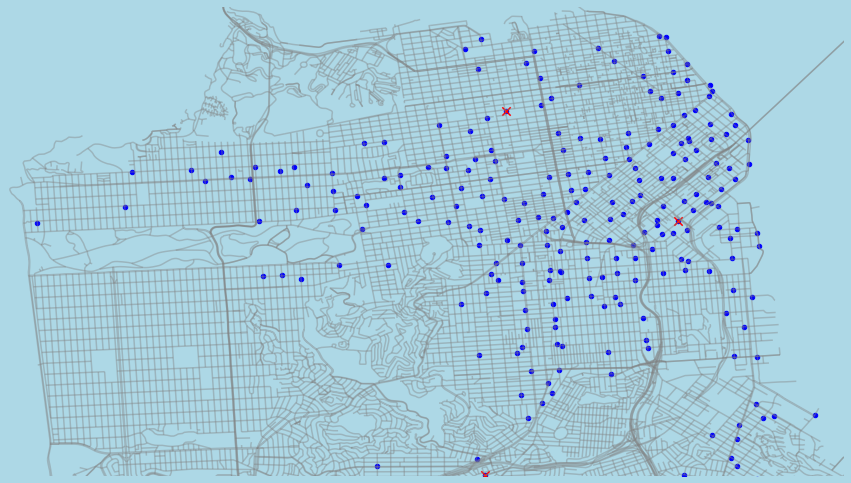

In [26]:
## just to get a vis for blog
#visualize where the missing values are
fig,ax = plt.subplots(figsize=(15,15),
                     facecolor='lightblue')
map = gpd.read_file('geo/bayarea/tl_2019_06075_roads.shp')
map.plot(ax=ax, alpha= 0.4, color='grey')  #map = geo/bayarea/tl_2019_06075_roads.shp
ax.set_facecolor('lightblue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(
    axis='both',        
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False, 
    left=False,
        labelleft=False,
    labelbottom=False)

#need to set some boundaries! 
xl = geo_df.lon.min() - .005
xr = geo_df[sf_proper].lon.max() + .005
yb = 37.73
yt = geo_df[sf_proper].lat.max() + .005
plt.xlim(xl,xr)
plt.ylim(yb,yt)
#geo_df.plot(ax = ax , markersize = 20, c = 'blue', marker = 'o') #after 1 run, we are lucky they are all in sf 
#filter only SF stations
geo_df[sf_proper].plot(ax = ax , markersize = 20, c = 'blue', marker = 'o')   #non
geo_df[noregion].plot(ax = ax , markersize = 70, c = 'red', marker = 'x', label = geo_df['station_id'])

plt.savefig('station_background.jpg',facecolor='lightblue')  #save locally for blog post
plt.show()
# we can see that the 8 rows missing region id are within the SF area. so we will assign region_id=3


In [ ]:
# we can see that the 8 rows missing region id are within the SF area. so we will assign region_id=3
geo_df['region_id'].replace(to_replace=np.nan, value='3', inplace=True)
#that should take are of those 8 values
geo_df.set_index('station_id', inplace=True)  #fornow this makes sense


#test another shapefile 
shapefile = 'geo/bayarea/tl_2015_06_prisecroads.shp'

bikeways = gpd.read_file(shapefile)

fig,ax = plt.subplots(figsize=(15,15))
bikeways.plot(ax=ax, alpha= 0.3, color='grey')
ax.set_title(shapefile)
crs = {'init': 'epsg:4326'}
geometry = [Point(xy) for xy in zip( station_info.lon, station_info.lat)]  #long, lat! == x,y 
#geometry[:3]  # whatss thsi for
geo_df = gpd.GeoDataFrame(station_info.copy(),
                         crs =crs,
                         geometry = geometry)

geo_df[sf_proper].plot(ax = ax , markersize = 20, c = 'blue', marker = 'o')
plt.show()

In [ ]:
#investigate the short name field...it looks like an abbreviation followed bya map grid,.
print(geo_df.columns)
geo_df.short_name.str.extract('([A-Z]+)-')[0].value_counts()  # interesting, the prefix corresponds to a locality.


regions = geo_df.copy()[['region_id','short_name' ]]     #create a table mapping station id to region info
regions['city'] = regions.short_name.str.extract('([A-Z]+)-')
regions.sort_values(by='region_id',inplace=True)
regions.groupby(by=['region_id','city']).head()
regions[regions.city.isnull()]
bad = regions[regions.city.isnull()].index[0]
regions.columns
regions.loc[bad, 'city'] = 'SF'
regions.groupby(by=['region_id','city']).head()
c1 = regions.city == 'SF'
c2 = regions['region_id'].isnull()
c3 = c1 & c2
regions[c2] # thats all of them, will replace with 3, 
regions.replace(to_replace=np.nan, value='3', inplace=True)
print(regions.isnull().sum())
regions.drop_duplicates(inplace=True)
regions.set_index('city')

#done for now, save file locally 
regions.to_csv('city_region.csv')
regions.head()

In [50]:
geo_df.to_csv('station_info.csv')
#saving geo dataframe
geo_df.head()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/dliu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-50-6ea20f0e554f>", line 1, in <module>
    geo_df.to_csv('station_info.csv')
  File "/home/dliu/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py", line 3228, in to_csv
    formatter.save()
  File "/home/dliu/anaconda3/lib/python3.7/site-packages/pandas/io/formats/csvs.py", line 183, in save
    compression=self.compression,
  File "/home/dliu/anaconda3/lib/python3.7/site-packages/pandas/io/common.py", line 399, in _get_handle
    f = open(path_or_buf, mode, encoding=encoding, newline="")
FileNotFoundError: [Errno 2] No such file or directory: 'station_info.csv'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/dliu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.p

FileNotFoundError: [Errno 2] No such file or directory: 'station_info.csv'

In [ ]:
#print('notebook runs from top to bottom')